In [2]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as T

from torch.utils.data import DataLoader, ConcatDataset
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR
import numpy as np

from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy.optimize import linear_sum_assignment 

In [3]:
mnist_transforms = T.Compose(
    [
        T.Resize((28, 28)),
        T.ToTensor(),
    ]
)

train_dataset = MNIST('mnist', train=True, transform=mnist_transforms, download=True)
valid_dataset = MNIST('mnist', train=False, transform=mnist_transforms, download=True)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=1024, shuffle=False, num_workers=0, pin_memory=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist\MNIST\raw\train-images-idx3-ubyte.gz to mnist\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist\MNIST\raw\train-labels-idx1-ubyte.gz to mnist\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to mnist\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to mnist\MNIST\raw



## Prepare

In [4]:
def train(
    model, optimizer, loss_fn, device
):
    model.train()
    model.to(device)

    if isinstance(model, DEC):
        if not model.initialized:
            xs = []
            ys = []
            
            static_loader = DataLoader(
                train_dataset,
                batch_size=256,
                pin_memory=False,
                shuffle=False,
            )

            for x, y in tqdm(static_loader, desc='Initialization of cluster centers'):
                x, y = x.to(device), y.to(device)
                x = x.reshape(-1, 28*28)
                xs.append(model.encoder(x).detach().cpu())
                ys.append(y)

            xs = torch.cat(xs)
            ys = torch.cat(ys)

            with torch.no_grad():
                model.kmeans.fit(xs)

                model.state_dict()["assignment.centroids"].copy_(
                    torch.tensor(model.kmeans.cluster_centers_)
                )

                init_acc = cluster_acc(ys.cpu().numpy(), model.kmeans.labels_)
                print('Initial accuracy:', init_acc)

                model.y_pred_previous_initiialized = False # necessary for delta initialization 
                    
            model.initialized = True
            print('Centroids weights were initialized.')

    train_loss = 0
    ys = []
    outputs = []
    counter = 0

    for x, y in tqdm(train_loader, desc='Train'):
        
        x, y = x.to(device), y.to(device)
        x = x.reshape(-1, 28*28)

        optimizer.zero_grad()

        if isinstance(model, DEC):
        
            if type(model) == DEC:
                q = model(x)
                p = model.get_target_distribution(q).detach()
                
                # output = q
                # y_pred = q.argmax(1)
                loss = loss_fn(q.log(), p)
                
            elif type(model) == IDEC:
                
                q, output = model(x)
                p = model.get_target_distribution(q).detach()

                loss = loss_fn(
                    q.log(), p,
                    output, x
                )

            ys.append(y)
            outputs.append(q.cpu().detach().argmax(1)) 

        elif isinstance(model, StackedAutoEncoder):
            output = model(x)
            loss = loss_fn(output, x)
        
        else:
            raise TypeError("Received model type is not supported. Use StackedAutoEncoder, StackedDenoisingAutoEncoder, DEC or IDEC")
        
        train_loss += loss.item()

        loss.backward()
        optimizer.step(closure=None)

    train_loss /= len(train_loader)

    if isinstance(model, DEC):
        
        y = torch.cat(ys).cpu().numpy()
        y_pred = torch.cat(outputs).numpy()

        return (
            train_loss,
            y, 
            y_pred,
        )
    elif isinstance(model, StackedAutoEncoder):
        return train_loss


In [5]:
@torch.inference_mode()
def evaluate(
    model, loader, loss_fn, device
):
    model.eval()

    eval_loss = 0

    outputs = []
    ys = []

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)
        x = x.reshape(-1, 28*28)

        if isinstance(model, DEC):
            if type(model) == DEC:

                q = model(x)
                p = model.get_target_distribution(q).detach()
                
                loss = loss_fn(q.log(), p)
                
            elif type(model) == IDEC:
                q, output = model(x)
                p = model.get_target_distribution(q).detach()
                
                loss = loss_fn(
                    q.log(), p,
                    output, x
                )

            ys.append(y)
            outputs.append(q.cpu().detach().argmax(1))

        elif isinstance(model, StackedAutoEncoder):
            output = model(x)
            loss = loss_fn(output, x)

        else:
            raise TypeError("Received model type is not supported. Use StackedAutoEncoder, StackedDenoisingAutoEncoder, DEC or IDEC")

        eval_loss += loss.item()

    eval_loss /= len(loader)


    if isinstance(model, DEC):
        with torch.no_grad():
            y = torch.cat(ys).cpu().numpy()
            y_pred = torch.cat(outputs).numpy()
            
        return (
            eval_loss,
            y,
            y_pred
        )
    elif isinstance(model, StackedAutoEncoder):
        return eval_loss
        

In [6]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()
    
    plt.show()

def plot_stats_dec_acc(
    train_loss: list[float],
    valid_loss: list[float],

    train_acc: list[float],
    val_acc: list[float],

    title: str
):
    plt.figure(figsize=(10, 5))

    plt.title(title + " loss")

    plt.plot(train_loss, label="Train loss")
    plt.plot(valid_loss, label="Valid loss")
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(10, 5))

    plt.title(title + " cluster accuracy")

    plt.plot(train_acc, label="Train acc", linewidth=1.5)
    plt.plot(val_acc, label="Valid acc", linewidth=1.5)

    plt.legend()
    plt.grid()

    plt.show()


def plot_stats_dec(
    train_loss: list[float],
    valid_loss: list[float],

    train_acc: list[float],
    train_nmi: list[float],
    train_ari: list[float],
    val_acc: list[float],
    val_nmi: list[float],
    val_ari: list[float],

    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + " loss")

    plt.plot(train_loss, label="Train loss")
    plt.plot(valid_loss, label="Valid loss")
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + " cluster accuracy, normalized mutual info score, adjusted random info score")

    plt.plot(train_acc, label="Train acc", linewidth=1.5)
    plt.plot(train_nmi, label="Train nmi", linestyle='dashdot')
    plt.plot(train_ari, label="Train ari", linestyle='dashed')

    plt.plot(val_acc, label="Valid acc", linewidth=1.5)
    plt.plot(val_nmi, label="Valid nmi", linestyle='dashdot')
    plt.plot(val_ari, label="Valid ari", linestyle='dashed')

    plt.legend()
    plt.grid()

    plt.show()



In [7]:
#!g1.1
from torchvision.utils import make_grid


@torch.inference_mode()
def visualize(model, xs):
    model.eval()

    to_pil = T.ToPILImage()

    xs = xs.reshape(-1, 28*28)

    outputs = model(xs.to(device)).cpu()
    
    plt.figure(figsize=(20, 4))
    
    plt.imshow(
        to_pil(
            torch.cat(
                (
                    make_grid(xs[:10], nrow=10, pad_value=1),
                    make_grid(outputs[:10], nrow=10, pad_value=1)
                ),
                dim=1
            )
        )
    )
    
    plt.axis('off')

    plt.show()


In [8]:
#!g1.1
def whole_train_valid_cycle(
    model, scheduler, optimizer, loss_fn, device, title,
    num_epochs:int = 100, 
    delta_threshold:int = None, 
    save_best_params_as:str = None
):
    train_loss_history, valid_loss_history = [], []
    
    best_valid_loss = np.inf
    best_val_acc = 0

    train_acc_history, train_nmi_history, train_ari_history = [], [], []
    val_acc_history, val_nmi_history, val_ari_history = [], [], []

    for epoch in range(num_epochs):

        if isinstance(model, DEC):

            train_loss, train_y, train_y_pred, = train(model, optimizer, loss_fn, device)

            if not model.y_pred_previous_initiialized:
                train_y_pred_previous = np.copy(model.kmeans.labels_)
                model.y_pred_previous_initiialized = True
           

            # check delta threshold after train loop
            delta = (train_y_pred != train_y_pred_previous).sum() / len(train_y_pred_previous)
            if delta_threshold is not None and delta < delta_threshold:
                print(
                    'Early stopping as current delta "%1.5f" less than "%1.5f" delta threshold.'
                    % (delta, delta_threshold)
                )
                break
            if model.y_pred_previous_initiialized:
                train_y_pred_previous = np.copy(train_y_pred)
            
            # start evaluation loop
            valid_loss, val_targets, val_predicted = evaluate(model, valid_loader, loss_fn, device)
    
            
            train_acc = cluster_acc(train_y, train_y_pred)
            train_nmi = normalized_mutual_info_score(train_y, train_y_pred)
            train_ari = adjusted_rand_score(train_y, train_y_pred)

            train_acc_history.append(train_acc)
            train_nmi_history.append(train_nmi)
            train_ari_history.append(train_ari)

            val_acc = cluster_acc(val_targets, val_predicted)
            val_nmi = normalized_mutual_info_score(val_targets, val_predicted)
            val_ari = adjusted_rand_score(val_targets, val_predicted)

            val_acc_history.append(val_acc)
            val_nmi_history.append(val_nmi)
            val_ari_history.append(val_ari)

        elif isinstance(model, StackedAutoEncoder):
            train_loss = train(model, optimizer, loss_fn, device)
            valid_loss = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)


        clear_output(wait=True)
        
        # visualize(model, next(iter(valid_loader))[0])

        if isinstance(model, DEC):
            plot_stats_dec(
                train_loss_history, valid_loss_history, 
                train_acc_history, train_nmi_history, train_ari_history,
                val_acc_history, val_nmi_history, val_ari_history,
                title,
            )

        elif isinstance(model, StackedAutoEncoder):

            plot_stats(
                train_loss_history, valid_loss_history,
                title
            )
            # scheduler only for autoencoder
            scheduler.step()


        if not save_best_params_as == None:
            if isinstance(model, StackedAutoEncoder):
                if valid_loss < best_valid_loss: 
                    best_valid_loss = valid_loss
                    torch.save(model.state_dict(), save_best_params_as)
                    print(f"Model parameters saved to '{save_best_params_as}'")
            if isinstance(model, DEC):
                if val_acc > best_val_acc: 
                    best_val_acc = val_acc
                    torch.save(model.state_dict(), save_best_params_as)
                    print(f"Model parameters saved to '{save_best_params_as}'")

            

## Net

In [9]:
#!g1.1
class Block(nn.Module):
    def __init__(
        self, 
        inp_dim: int, 
        out_dim: int,
        activation: nn.Module,
        dropout_value: float
    ):
        super().__init__()
        self.fc1 = nn.Linear(inp_dim, out_dim)
        self.act = activation()
        self.dropout = nn.Dropout(dropout_value)
 
    def forward(self, x):
        return self.dropout(
            self.act(self.fc1(x))
        )

class StackedAutoEncoder(nn.Module):
    def __init__(
        self, 
        dims:list, 
        activation:nn.Module = nn.ReLU,
        dropout_value:float = .0,
        base_block:nn.Module = Block,
    ):
        """
        Fully connected auto-encoder model, symmetric.
        Arguments:
            dims: list of number of units in each layer of encoder. dims[0] is input dims, dims[-1] is units in hidden layer.
                The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
            act: activation, not applied to Input, Hidden and Output layers
        return:
            Model of autoencoder
        """
        super().__init__()
        self.dims = dims
        self.inp_dim = dims[0]
        self.hid_dim = dims[-1]
        self.dropout_value = dropout_value
        self.activation = activation

        # encoder
        encoder_blocks = []
        encoder_blocks.extend([
            base_block(self.inp_dim, dims[1], nn.Identity, dropout_value),
            base_block(dims[1], dims[2], activation, dropout_value),
            base_block(dims[2], dims[3], activation, dropout_value),
            base_block(dims[3], self.hid_dim, nn.Identity, dropout_value),
        ])

        self.encoder = nn.Sequential(*encoder_blocks) 

        # decoder
        decoder_blocks = []
        decoder_blocks.extend([
            base_block(self.hid_dim, dims[3], activation, dropout_value),
            base_block(dims[3], dims[2], activation, dropout_value),
            base_block(dims[2], dims[1], activation, dropout_value),
            base_block(dims[1], self.inp_dim, nn.Identity, dropout_value), #nn.Identity f(x)==x
        ])
        
        self.decoder = nn.Sequential(*decoder_blocks)

        # self.encoder.apply(self._init_weight)
        # self.decoder.apply(self._init_weight)

    def set_dropout_value(self, value:float):
        self.dropout_value = value

        for i in range(len(self.encoder)):
            self.encoder[i].dropout.p = self.dropout_value
        for i in range(len(self.decoder)):
            self.decoder[i].dropout.p = self.dropout_value

    def _init_weight(self, layer):
        if type(layer) == nn.Linear:
            nn.init.normal_(layer.weight, mean=0.0, std=0.01)  # follow paper setting
            nn.init.constant_(layer.bias, 0)


    def forward(self, x):
        self.set_dropout_value(self.dropout_value) # inplace

        return self.decoder(self.encoder(x))



In [10]:
class DenoisingBlock(Block):
    def __init__(
        self, 
        inp_dim: int, 
        out_dim: int,
        activation: nn.Module,
        dropout_value: float
    ):
        super().__init__(inp_dim, out_dim, activation, dropout_value)
                
    def forward(self, x):
        if self.training:
            x = x + torch.randn_like(x) * 0.05

        return self.act(
            self.dropout(self.fc1(x))
        )


class StackedDenoisingAutoEncoder(StackedAutoEncoder):
    def __init__(
        self, 
        dims:list, 
        activation: nn.Module = nn.ReLU,
        dropout_value: float = .0,
        base_block: nn.Module = DenoisingBlock,
    ):
        super().__init__(dims, activation, dropout_value, base_block,)

    def forward(self, x):
        if self.training:
            x = torch.clip(x + torch.randn_like(x) * 0.1, min=0, max=1)

        return self.decoder(self.encoder(x))


In [11]:
from sklearn.cluster import KMeans

class ClusterAssignment(nn.Module):
    def __init__(
        self,
        num_cluster: int,
        hidden_dim: int,
        alpha: float = 1.0,
        centroids: torch.tensor = None,
    ):
        """ 
        student t-distribution, as same as used in t-SNE algorithm.
                    q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            num_cluster: 
            hidden_dim: 
            alpha:
            centroids:
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        super().__init__()
        self.num_cluster = num_cluster
        self.hidden_dim = hidden_dim
        self.alpha = alpha
        self.centroids = centroids
        
        if centroids is None:
            centroids = torch.zeros(
                self.num_cluster, self.hidden_dim, dtype=torch.float
            )
            nn.init.xavier_uniform_(centroids)

        self.centroids = nn.Parameter(centroids)


    def forward(self, z):
        z, self.centroids = z.to(device), self.centroids.to(device)

        diff = torch.sum((z.unsqueeze(1) - self.centroids) ** 2, 2)
        numerator = 1.0 / (1.0 + (diff / self.alpha))
        power = (self.alpha + 1.0) / 2
        numerator = numerator ** power
        q = numerator / torch.sum(numerator, dim=1, keepdim=True)
        return q


class DEC(nn.Module):
    def __init__(
        self, 
        autoencoder: nn.Module,
        n_clusters: int = 10,
        alpha: float = 1.0,
        centroids = None,
    ):
        '''
        Deep Embedded Clustering
        '''
        super().__init__()
        self.encoder = autoencoder.encoder
        self.n_clusters = n_clusters
        self.hidden_dim = autoencoder.hid_dim
        self.alpha = alpha

        self.assignment = ClusterAssignment(
            n_clusters, autoencoder.hid_dim, alpha, centroids
        )
        self.kmeans = KMeans(n_clusters, n_init=20)
        self.initialized = False
        

    def forward(self, x):
        return self.assignment(self.encoder(x))

    def get_target_distribution(self, q):
        numerator = (q ** 2) / torch.sum(q, 0)
        p = (numerator.t() / torch.sum(numerator, 1)).t()
        return p


class IDEC(DEC):
    def __init__(
        self, 
        autoencoder: nn.Module,
        n_clusters: int = 10,
        alpha: float = 1.0,
    ):    
        super().__init__(
            autoencoder,
            n_clusters,
            alpha,
        ) 
        self.decoder = autoencoder.decoder
   
    
    def forward(self, x):
        return(
            self.assignment(self.encoder(x)),
            self.decoder(self.encoder(x))
        )
    

In [12]:
def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    
    return w[row_ind, col_ind].sum() / y_pred.size
    

In [13]:
class IDEC_loss(nn.Module):
  def __init__(self, gamma=.1):
    super().__init__();
    self.gamma = gamma

  def forward(self, pred_cl, targ_cl, pred_rec, targ_rec, ):
    """
    See original paper for explanation
    """
    loss_cl = nn.KLDivLoss(reduction='batchmean')
    loss_rec = nn.MSELoss()
    return loss_rec(pred_rec, targ_rec) + self.gamma * loss_cl(pred_cl, targ_cl)
    

## Initialize

In [14]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

cuda:0
NVIDIA GeForce GTX 1060 with Max-Q Design


## Run Autoencoder

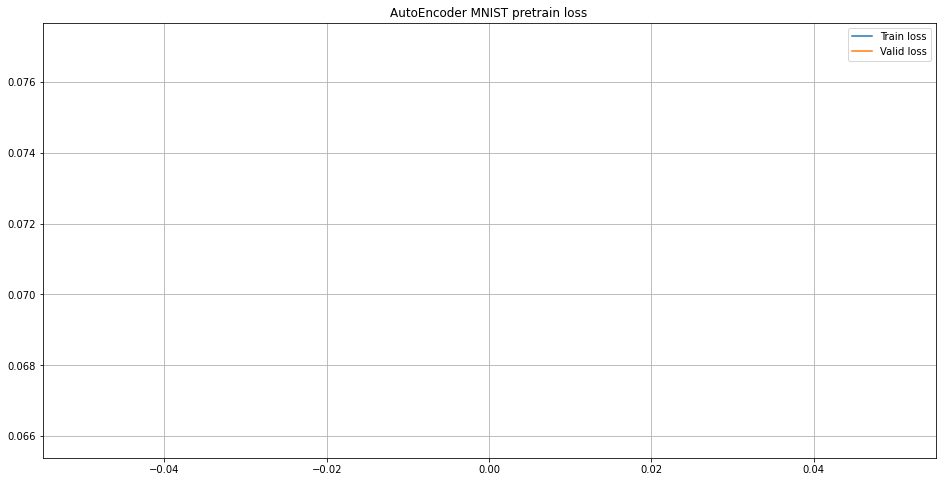

Model parameters saved to '.\weights\pretrain-model-parameters4mnist.pt'


Train:  47%|████▋     | 111/235 [00:05<00:06, 19.32it/s]


KeyboardInterrupt: 

In [22]:
loss_fn = nn.MSELoss()
model = StackedDenoisingAutoEncoder(dims=[784, 500, 500, 2000, 10], dropout_value=.02)

# optimizer = Adam(model.parameters(), lr=1e-3)
optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=20, gamma=0.1) # 60~=20000/256


whole_train_valid_cycle(
    model, 
    scheduler,
    optimizer,
    loss_fn,
    num_epochs = 300, 
    device = device,
    save_best_params_as = '.\weights\pretrain-model-parameters4mnist.pt',
    title='AutoEncoder MNIST pretrain'
)

In [ ]:
# model.load_state_dict(torch.load(r'pretrain-model-parameters4mnist.pt'))

<All keys matched successfully>

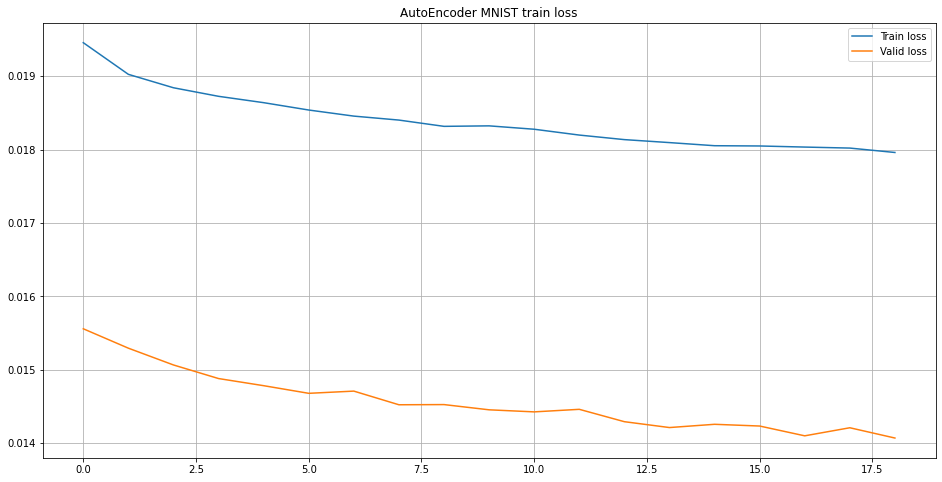

Model parameters saved to '.\weights\train-model-parameters4mnist.pt'


Train:  69%|██████▉   | 163/235 [00:11<00:04, 14.70it/s]


KeyboardInterrupt: 

In [18]:
model.set_dropout_value(.02)
optimizer = Adam(model.parameters(), lr=1e-3)
# optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

whole_train_valid_cycle(
    model, 
    scheduler,
    optimizer,
    loss_fn,
    num_epochs = 100, 
    device = device,
    title ='AutoEncoder MNIST train',
    save_best_params_as = r'.\weights\train-model-parameters4mnist.pt',
)

## Run DEC

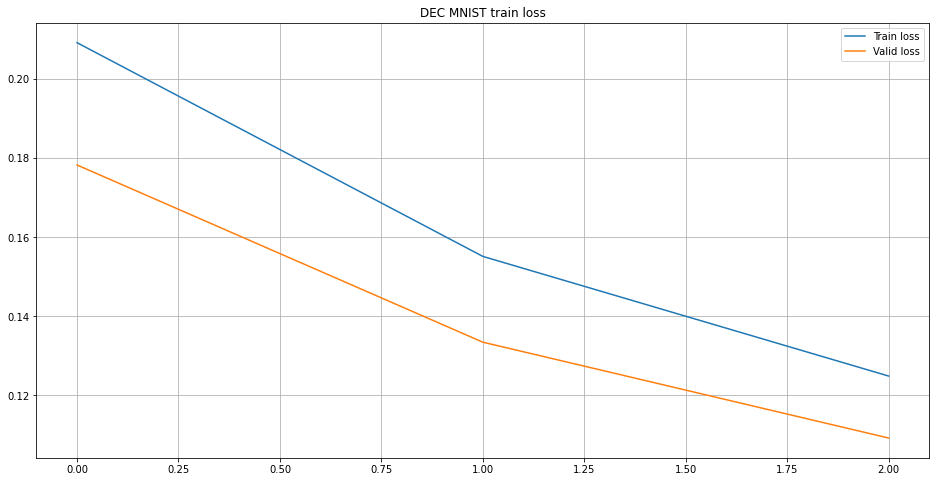

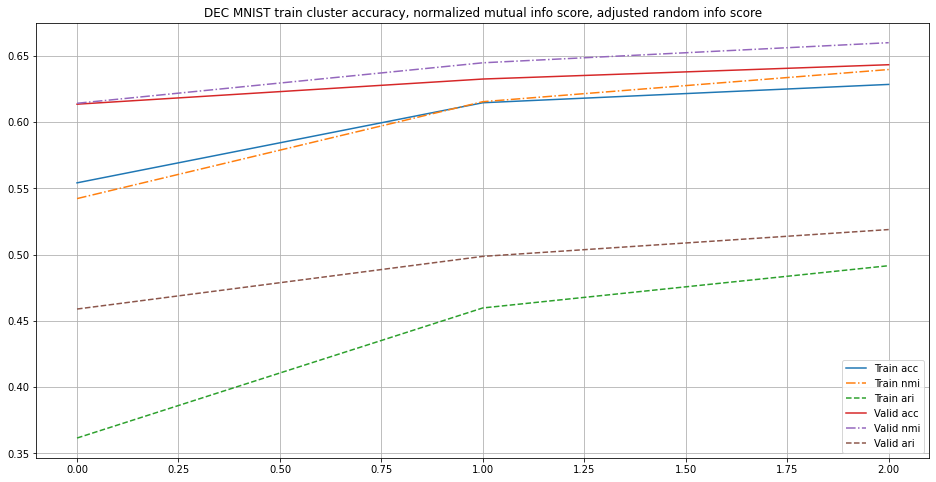

Train:  71%|███████▏  | 168/235 [00:13<00:05, 12.26it/s]


KeyboardInterrupt: 

In [418]:
model = StackedAutoEncoder(dims=[784, 500, 500, 2000, 10], dropout_value=.01)

model_state_dict = torch.load(r'best-model-parameters4mnist_2.pt')
model.load_state_dict(model_state_dict)


dec = DEC(autoencoder = model)
loss_fn = nn.KLDivLoss(reduction='batchmean')

optimizer = Adam(dec.parameters(), lr=1e-4)
# optimizer = SGD(dec.parameters(), lr=.01, momentum=0.9)

whole_train_valid_cycle(
    dec,
    None,
    optimizer,
    loss_fn,
    num_epochs = 100,
    delta_threshold = .1,
    # save_best_params_as = '.\weights\dec_weights.pt'
    device = device,
    title='DEC MNIST train'
)


In [ ]:
# .51 init cluster acc
# .68 w/dec 
# torch.save(dec.state_dict(), 'dec_weights.pt')

## Run IDEC

In [ ]:
# dec.load_state_dict(torch.load(r'dec_weights.pt'))

<All keys matched successfully>

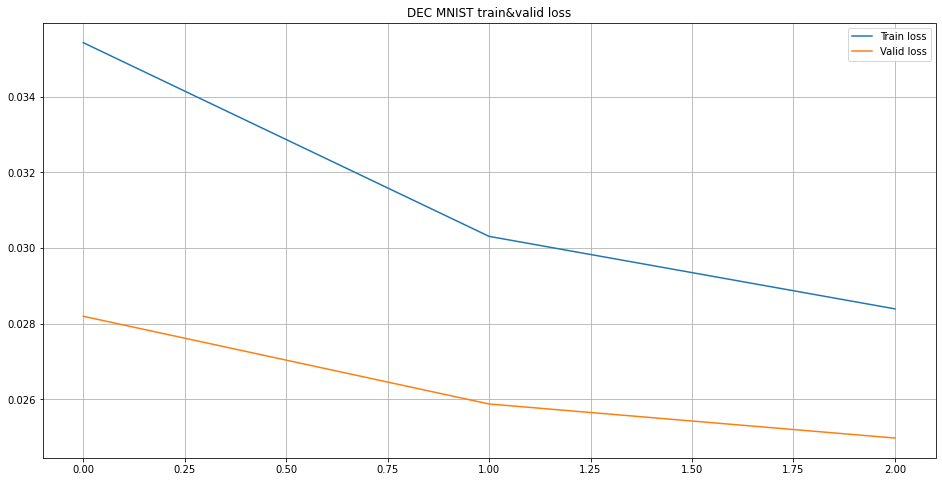

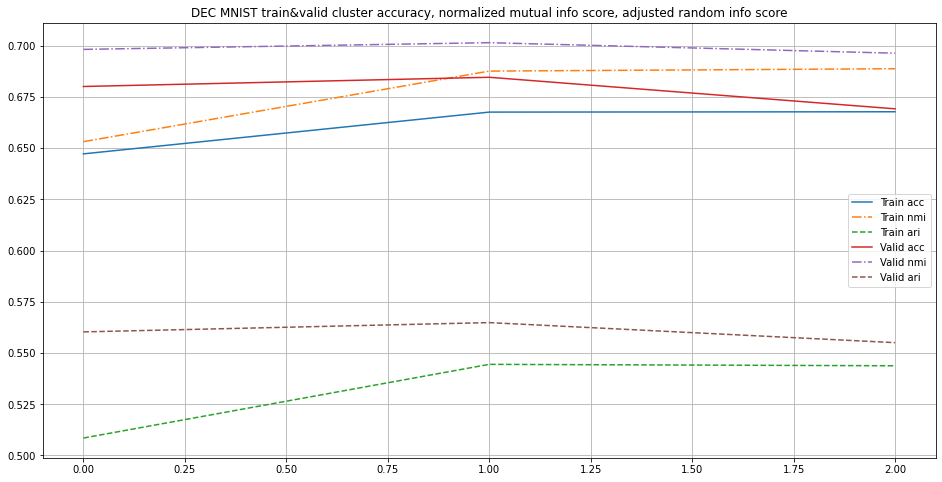

Train:   1%|          | 2/235 [00:00<00:14, 16.46it/s]


KeyboardInterrupt: 

In [16]:
model = StackedAutoEncoder(dims=[784, 500, 500, 2000, 10], dropout_value=.01)

model.load_state_dict(torch.load(r'best-model-parameters4mnist.pt'))

idec = IDEC(autoencoder=model)
loss_fn = IDEC_loss(gamma=.1)

optimizer = Adam(idec.parameters(), lr=1e-3,  betas = (.9, .999))
# optimizer = SGD(idec.parameters(), lr=0.01, momentum=0.9)

whole_train_valid_cycle(
    idec,
    None,
    optimizer,
    loss_fn,
    num_epochs = 100,
    delta_threshold = .1,
    # save_best_params_as = 'idec_weights.pt',
    device=device,
    title='DEC MNIST train&valid'
)

In [ ]:
# torch.save(idec.state_dict(), 'idec_weights.pt')

In [349]:
def predict_cluster_accuracy(model, loader):
    model.to(device)
    targets, predicted = [], []
    kmeans_preds = []

    xs, ys = [], []

    for x, y in tqdm(loader, desc='Evaluate cluster accuracy'):
        x, y = x.to(device), y.to(device)
        x = x.reshape(-1, 28*28)
        
        q = model(x)

        y_pred = q.argmax(1)

        targets.append(y)
        predicted.append(y_pred)

        xs.append(model.encoder(x).detach().cpu())
        ys.append(y)

    xs = torch.cat(xs)
    ys = torch.cat(ys)

    with torch.no_grad():
        km = KMeans(n_clusters=10, n_init=20).fit(xs)


    return cluster_acc(
        torch.cat(targets).cpu().numpy(), 
        torch.cat(predicted).cpu().numpy()
    ), cluster_acc(
        ys.cpu().numpy(),
        km.labels_
    )

In [350]:
from ptsdae.sdae import StackedDenoisingAutoEncoder as Sdae
from ptdec.dec import DEC as __DEC

autoencoder = Sdae(
    [28 * 28, 500, 500, 2000, 10], final_activation=None
)
# def rename_attribute(obj, old_name, new_name):
#     obj.__dict__[new_name] = obj.__dict__.pop(old_name)

# from typing import OrderedDict
state_dict = OrderedDict((k.replace('linear','fc1') if 'encoder' or 'decoder' in k else k, v) for k, v in autoencoder.state_dict().items())

pt_dec = __DEC(cluster_number=10, hidden_dimension=10, encoder=autoencoder.encoder)

In [368]:
# pt_dec.load_state_dict(torch.load(r'b4_dec_train.pt'))
predict_cluster_accuracy(autoencoder, train_loader)

Evaluate cluster accuracy: 100%|██████████| 235/235 [00:24<00:00,  9.40it/s]


(0.43316666666666664, 0.5593666666666667)

In [355]:
pt_dec.state_dict().keys()

odict_keys(['encoder.0.linear.weight', 'encoder.0.linear.bias', 'encoder.1.linear.weight', 'encoder.1.linear.bias', 'encoder.2.linear.weight', 'encoder.2.linear.bias', 'encoder.3.linear.weight', 'encoder.3.linear.bias', 'assignment.cluster_centers'])